In [1]:
%matplotlib inline
from IPython.display import Image
from IPython.display import Math
from IPython.display import Latex

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Mon Jan 21 11:37:16 2019


In [169]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()
import matplotlib.pyplot as plt


In [58]:
from dataclasses import dataclass

In [271]:
from  invisible_cities.core.system_of_units import *

In [265]:
@dataclass
class FoV:
    x : float
    y : float
    z : float
        
    def area(self)->float:
        return self.x * self.y
    
    def volume(self)->float:
        return self.x * self.y * self.z

    def __repr__(self):
        s ="""
        FOV; x = {0:5.1e} mm; y = {1:5.1e} mm; z = {2:5.1e} mm; area = {3:5.1e} mm2 volume = {4:5.1e} mm3
        """.format(self.x/mm, self.y/mm, self.z/mm, self.area()/mm2, self.volume()/mm3) 
                   
        return s
 
    
@dataclass
class LaserBeam:
    lamda   : float
    power   : float
    reprate : float
    
    def photon_energy(self) -> float:
        lnm = self.lamda / nm
        return ((1240)/ lnm)*eV
    
    def pulse_width(self) -> float:
        return 1./ self.reprate 

    def energy(self, time : float) -> float:
        return self.power * time

    def power_flux(self, fov : FoV) -> float:
        return self.power / fov.area()
    
    
    def __repr__(self):
        s ="""
        Laser:
        lamda                     ={0:5.1e} nm
        photon energy             ={1:5.1e} eV
        power                     ={2:5.1e} mW
        repetition rate           ={3:5.1e} kHz
        pulse width               ={4:5.1e} ms
        energy per pulse          ={5:5.1e} muJ
        """.format(self.lamda/nm, 
                   self.photon_energy()/eV,
                   self.power/miliwatt, 
                   self.reprate/kHz, 
                   self.pulse_width()/millisecond, 
                   self.energy(self.pulse_width())/microjoule)
        return s
    
def power_density(lb : LaserBeam, fov : FoV)->float:
    return lb.power / fov.area()

def photon_density(lb : LaserBeam, fov : FoV, time : float)->float:
    return power_density(lb, fov) * time / lb.photon_energy()


@dataclass
class Molecule:
    name  : str
    sigma : float
    Q     : float
    
    def __repr__(self):
        s ="""
        Molecule name ={0}; cross section = {1:5.1e} cm2; Q = {2:5.1f}
        """.format(self.name, 
                   self.sigma/cm2,
                   self.Q)
        return s

def fluorescence_per_molecule(m: Molecule, I: float, time: float)->float:
    """
    Returns the number of photons per molecule and time emitted by fluorescence.
    Parameters:
        m     : defines molecule
        I     : photon density
        time  : time 
    
    """
    return m.sigma * m.Q * I


@dataclass
class DyeSample:
    name          : str
    concentration : float
    volume        : float
    Avogadro      : float = 6.023E+23

    def n_molecules(self)->float:
        return self.Avogadro * self.concentration * self.volume

    def __repr__(self):
        s ="""
        Dye name ={0}; concentration = {1:5.1e} mole/l; V = {2:5.1e} l, nof molecules = {3:5.1e}
        """.format(self.name, 
                   self.concentration/(mole/l),
                   self.volume/l,
                   self.n_molecules())
                   
        return s

@dataclass
class Microscope:
    name              : str
    numerical_aperture : float  
    magnification     : float 
    eff_dichroic      : float = 0.85 
    eff_filter        : float = 0.8
    NA                : float = 1.4
    M                 : float = 100
    T                 : float = 0.3

    
    def optical_transmission(self)->float:
        f1 = self.numerical_aperture / self.NA
        f2 = self.magnification / self.M
        return self.T * (f1/f2)**2 
    
    def filter_transmission(self)->float:
        return self.eff_dichroic * self.eff_filter

    def transmission(self)->float:
        return self.optical_transmission() * self.filter_transmission()

    def __repr__(self):
        s ="""
        name                 = {0}
        NA                   = {1:5.1f} 
        M                    = {2:5.1f} 
        eff dichroic         = {3:5.2f} 
        eff filter           = {4:5.2f} 
        Optical transmission = {5:5.2f}
        Filter  transmission = {6:5.2f}
        Total transmission   = {7:5.2f}
        """.format(self.name,
                   self.numerical_aperture, 
                   self.magnification,
                   self.eff_dichroic,
                   self.eff_filter,
                   self.optical_transmission(),
                   self.filter_transmission(),
                   self.transmission())
                   
        return s

def diffraction_limit(l : LaserBeam, mc : Microscope)->float:
    return l.lamda/(2 * mc.numerical_aperture)

@dataclass
class CCD:
    name             : str = "C9100-23B"
    n_pixels         : ()  = (512, 512) 
    size_pixels      : ()  = (16 * micron, 16 * micron) 
    effective_area   : ()  = (8.19 * mm, 8.19 * mm)
    linear_full_well : ()  = (3.7E+5, 1.5E+5) # electrons
    pixel_clock_rate : ()  = (22 * MHZ, 11 * MHZ, 0.6875 * MHZ)
    dark_current     : float  = 0.005 # electron/pixel/s
    readout_noise    : float  = 8 # electron
    readout_speed    : float  = 72 # frames/s 
    
    def pixels (self)->float:
        return self.n_pixels[0] * self.n_pixels[1]
    
    def efficiency(self, lamda : np.array)->np.array:
        xp = np.array([300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000])
        fp = np.array([0.1,0.2,0.55,0.8,0.92,0.98,0.98,0.92,0.9,0.8,0.7,0.55,0.4,0.2,0.1])
        return np.interp(lamda/nm, xp, fp)

def photoelectrons_per_pixel(np : float, ccd : CCD)->float:
    return np / ccd.pixels()
        

# SABAT SMFI

## Authors

- J.J. Gomez-Cadenas 
- F. Monrabal
- Austin McDonald 

[NEXT](https://next.ific.uv.es/next/)

#### Contact


- [Email](mailto:jjgomezcadenas@dipc.org)




# This presentation

- Introduces some elementary concepts on fluorescent molecules and microscopy
- Reviews quantitatively NEXT PRL on Ba++ SMFI (NPRL from now on)
- Presents working lines for the SABAT program

# Elementary concepts

## Fluorescent molecules 

- In the most basic sense fluorescence is a photon energy reducer. The molecule takes in a higher energy photon (short wavelength) and emits a lower energy one (longer wavelength). The difference in excitation and emission is know as the Stokes shift, and in general the larger the Stoke shift.

<img align="center" src="img/EmissionAbsorptionAlexa.png" width="500" height="500"></img>


## Fluorescein

- Fluorescein is the base fluorescent molecule for NPRL studies. A fluorescent molecule is a rigid molecule that emits light (stokes-shifted) when excited and requires no alteration to its energy levels. 


<img align="center" src="img/fluoresceingMol.png" width="200" height="200"></img>
<img align="center" src="img/Fluorescein.png" width="500" height="500"></img>



## Fluorophore absorption

<img align="center" src="img/FluoroAbs.pdf" width="800" height="800"></img>


<img align="center" src="img/Beer-Lambert.png" width="800" height="800"></img>



<img align="center" src="img/FqY.png" width="800" height="800"></img>


## Fluorescent indicator

- A fluorescent indicator is a more complex molecule that usually requires some external bond or ion capture in order for its energy levels to allow photon emission. Fluo-3, Fluo-4 and C826 are fluorescent indicators. When it is not in the presence of a dication it can de-excite through its vibrational degrees of freedom, and in the presence of a certain dications the vibrational freedom is limited and photon emission is allowed. 


<img align="center" src="img/Fluo3Fluo4.png" width="500" height="500"></img>

- When the molecule ix complexed with the right dictation (e.g, Ca++ in figure) we say that the molecule is chelated.
- In the case of a fluorescent indicator, chelated molecules emit more than unchelated molecules

<img align="center" src="img/Fluo3.png" width="500" height="500"></img>
<img align="center" src="img/fluo3Spectra.png" width="500" height="500"></img>


## Fading, quenching and photobleaching

- The general term for a reduction of fluorescence emission intensity is fading, a catch-all category that is usually further subdivided into quenching and photobleaching phenomena for more precise descriptions. 
- Photobleaching is the irreversible decomposition of the fluorescent molecules in the excited state because of their interaction with molecular oxygen before emission. 
- The excited state relaxation process of quenching results in reduced fluorescence intensity through a variety of mechanisms involving non-radiative energy loss and frequently occurs as a result of oxidizing agents or the presence of salts or heavy metals or halogen compounds. 
- In some cases, quenching results from the transfer of energy to another molecule (termed the acceptor), which resides physically close to the excited fluorophore (the donor), a phenomenon known as fluorescence resonance energy transfer (FRET). 

## Where to find more:

http://priede.bf.lu.lv/grozs/Mikrobiologijas/BiotehIII/2013/Fluores_Theory_.pdf

http://priede.bf.lu.lv/grozs/Mikrobiologijas/BiotehIII/2013/Fluorescence%20handout.pdf


# Elementary concepts in microscopy

- An introduction to fluorescence microscopy can be found [here](https://www.microscopyu.com/techniques/fluorescence/introduction-to-fluorescence-microscopy). In the next slides 

## Fluorescent microscope


<img align="center" src="img/epiFluorescentMicroscope.png"></img>



- Illustrated in figure is a cutaway diagram of a modern epi-fluorescence microscope equipped for both transmitted and reflected fluorescence microscopy. 
- The vertical illuminator in the center of the diagram has the light source positioned at one end and the filter cube turret at the other. 
- The design consists of a basic reflected light microscope in which the wavelength of the reflected light is longer than that of the excitation. 
- In a fluorescence vertical illuminator, light of a specific wavelength is produced by passing multispectral light from an arc-discharge lamp through a wavelength selective excitation filter. Wavelengths passed by the excitation filter reflect from the surface of a dichromatic (also termed a dichroic) mirror or beamsplitter, through the microscope objective to bath the specimen with intense light. 
- If the specimen fluoresces, the emission light gathered by the objective passes back through the dichromatic mirror and is subsequently filtered by a barrier (or emission) filter, which blocks the unwanted excitation wavelengths.

## Epi-fluorescence illumination 

- In Epi-fluorescence illumination the reflected light vertical illuminator is interposed between the observation viewing tubes and the nosepiece housing the objectives. The illuminator is designed to direct light onto the specimen by first passing the excitation light through the microscope objective (which in this configuration, acts as a condenser) on the way toward the specimen, and then using that same objective to capture the emitted fluorescence. 
- This type of illuminator has several advantages. 

    a. The fluorescence microscope objective serves first as a well-corrected condenser and secondly as the image-forming light gatherer. Being a single component, the objective/condenser is always in perfect alignment.
    
    b. A majority of the excitation light reaching the specimen passes through without interaction and travels away from the objective, and the illuminated area is restricted to that which is observed through the eyepieces. 
        
    c. The full numerical aperture of the objective is available when the microscope is properly configured.

## Steering of the ligth. Filters

<img align="center" src="img/FluorescenceFilters.png" width="300" height="300"></img>

- Excitation light travels along the illuminator perpendicular to the optical axis of the microscope, passes through collector lenses and impinges upon the excitation filter where selection of the desired band and blockage of unwanted wavelength occurs. 
- The selected wavelengths, after passing through the excitation filter, reach the dichromatic beamsplitting mirror, which reflects shorter wavelength light and passes longer wavelength light. 
- The dichromatic beamsplitter is tilted at a 45-degree angle with respect to the incoming excitation light and reflects this illumination at a 90-degree angle directly through the objective optical system and onto the specimen. 
- Fluorescence emission produced by the illuminated specimen is gathered by the objective, now serving in its usual image-forming function. 
- Because the emitted light consists of longer wavelengths than the excitation illumination, it is able to pass through the dichromatic mirror and upward to the observation tubes or electronic detector.

## Numerical aperture

See: https://www.microscopyu.com/microscopy-basics/numerical-aperture

# NPRL Experiment


<img align="center" src="img/smfi_uta_setup.png" width="500" height="500"></img>



- The first setup used to measure the response in disolution (no cover slip) was similar (simpler)

<img align="center" src="img/AustinFirstSetup.png" width="500" height="500"></img>





## Microscope

- The apparatus is an [Olympus IX-70 inverted fluorescence microscope frame](https://www.olympus-lifescience.com/en/microscope-resource/primer/techniques/fluorescence/ix70fluorescence/)
- The objective is an Olympus 100x 1.4 NA, and was used with Olympus immersion oil (n = 1.518). 
- Low-fluorescence coverslips of thickness 0.13 mm serve the combined role of sample substrates and imaging plane. 
- A Hamamatsu ImagEM X2 EM-CCD camera, was used to record the fluorescence emission. 
- The excitation source is an NKT Photonics SuperK EXTREME laser, which emits in a wide spectral range of 350-2350 nm. The laser light is filtered to a tunable band of width ± 1 nm in the visible range via an acousto-optical tunable filter (AOTF). The beam is then expanded, cleaned, and steered via an array of adjustable mirrors through a lens that focuses it onto the objective BFP. 
- Emission and excitation light are separated by a filter cube containing the dichroic mirror and emission and excitation filters. 
- Micrometer stages in the external optical system allow for focusing on the BFP and adjustment of the TIRF ray angle, and the image is brought into focus using sample stage adjustment on the microscope frame.

## TIRF

<img align="center" src="img/TIRF2.png" width="500" height="500"></img>



## CCD spectral response

- Hamamatsu C9100: https://www.hamamatsu.com/eu/en/product/type/C9100-23B/index.html
<img align="center" src="img/C9100.png" width="500" height="500"></img>


## SAMPLE PREPARATION 

- The studies use fluorophores that are immobilized at the sensor surface. This emulates the conditions in a HPGXe TPC detector, where the ions will drift to the sensor plate and adhere to fluorophores immobilized there. 
- The chosen method was to use a matrix of polyvinyl alcohol (PVA) trapping the fluors but allowing permeability of ions through-out the sample.
- Coverslips were inspected for defects and cleaned by ultrasonic bath in acetone for 30 minutes and then ethanol for 30 minutes. Once clean, they were placed in a vacuum oven at 340 K to bake overnight. A buffer solution (pH 7.2) was established using ACS Ultra Trace water with imidazole and hydrochloric acid. PVA was added (5% by weight) to form the working buffer and placed in a hot water bath. Once the PVA is fully dissolved it is removed from the bath and set on a stir plate, with water added to reach the target volume. After 30 minutes the solution reaches room temperature and <span style="color:red"> BAPTA is added to a concentration of 250 μM to suppress residual calcium.</span> 
- The SMFI fluor Fluo-3 is then added, to a concentration of 1 nM (<span style="color:blue"> This is only a guess, the initial concentration was close to 1 muM</span>) . 
- Three background samples were made by placing 50 μL of solution onto a coverslip then spin coating it at 1800 rpm for 10 seconds. These will be referred to as the “barium-free” samples. 
- Ba++ was then added in the form of barium perchlorate salt solution to a target concentration of 500 μM, to make three “barium-spiked” samples (<span style="color:blue"> The concentration is much larger than the concentration of the dye, so that most dye molecules in the spiked samples will be chelated</span>). 
- All samples were placed in an oven at 340 K for 4 hours, and then left to cure overnight at room temperature, in order to harden the PVA matrix.



## Fluo-3 and BAPTA

- Fluo-3. the molecule used in NPRL is fluorescin bonded to BAPTA. BAPTA is a dication chelator it is generally used reduces the amount of free dications (positive ions) in solution. 
- BAPTA is also used to reduce the amount of free ions in the disolution, as illustrated in Figure. 

<img align="center" src="img/BAPTA.png" width="400" height="400"></img>
<img align="center" src="img/efffectBATA.png" width="400" height="400"></img>


## Ba++ salt

$$ Ba(ClO_4)_2 \rightarrow Ba^{++} + 2 (CLO_4)^-$$

## Imaging 


- Prior to scanning the samples, the AOTF was set to <span style="color:red"> 488 nm </span>, which is the peak excitation wavelength for Fluo-3.
- The measured power entering the objective was <span style="color:red"> 1 μW </span>. 
- The external optics were adjusted to place the system into <span style="color:red"> total internal reflection mode </span> using prismatic alignment.
- Surface sensitivity was checked with fluorescent micro-spheres. 
- Each sample was then placed onto the microscope stage and scanned.
- The imaging protocol was to find a <span style="color:red"> 35x 35 μm2 Field of View (FOV) </span> where at least one fluorescent spot was present, and focus the microscope on that spot by minimizing its point spread.
- Once focus was achieved, images were taken every <span style="color:red"> 500 ms </span> for 375 s. 
- Then, a new FOV was found by randomly translating the sample stage and refocusing. 

<img align="center" src="img/prlFOV.png" width="500" height="500"></img> 

## Observation of SMFI

<img align="center" src="img/prlPhotobleaching.png" width="500" height="500"></img> 

# NPRL annnotated: 

## Beam

In [281]:

laser = LaserBeam(lamda = 488 * nm, power = 1 * microwatt, reprate = 1 * MHZ)
print(laser)
fov = FoV(x = 35 * micron, y = 35 * micron, z = 2 * 488 * nm)
print(fov)
print(f'power density for laser focused in FOV  = {power_density(luv,fov)/(W/cm2):5.1f} W/cm2')
I = photon_density(luv, fov, 0.5*second)
print(f'photon density for UV laser FOV (per pulse of 500 ms)  = {I/(1/cm2):5.1e} ph per cm2')



        Laser:
        lamda                     =4.9e+02 nm
        photon energy             =2.5e+00 eV
        power                     =1.0e-03 mW
        repetition rate           =1.0e+03 kHz
        pulse width               =1.0e-03 ms
        energy per pulse          =1.0e-06 muJ
        

        FOV; x = 3.5e-02 mm; y = 3.5e-02 mm; z = 9.8e-04 mm; area = 1.2e-03 mm2 volume = 1.2e-06 mm3
        
power density for laser focused in FOV  = 163.3 W/cm2
photon density for UV laser FOV (per pulse of 500 ms)  = 1.0e+20 ph per cm2


## Microscope

In [282]:
mc = Microscope(name='Olympus', numerical_aperture=1.4, magnification=100)
print(mc)


        name                 = Olympus
        NA                   =   1.4 
        M                    = 100.0 
        eff dichroic         =  0.85 
        eff filter           =  0.80 
        Optical transmission =  0.30
        Filter  transmission =  0.68
        Total transmission   =  0.20
        


## Molecule

In [288]:
m = Molecule(name='Fluo-3', sigma=9E-17 * cm2, Q = 0.8)
print(m)
flm = fluorescence_per_molecule(m, I, 0.5*second)
print('Fluorescence per molecule and pulse (500 ms) second = {0:5.1e}'.format(flm))



        Molecule name =Fluo-3; cross section = 9.0e-17 cm2; Q =   0.8
        
Fluorescence per molecule and pulse (500 ms) second = 7.4e+03


## Dye

In [289]:
ds = DyeSample(name = 'fluo3',  concentration = 1 * nanomole/l, volume = fov.volume())
print(ds)


        Dye name =fluo3; concentration = 1.0e-09 mole/l; V = 1.2e-12 l, nof molecules = 7.2e+02
        


## SFMI focusing

- Once a molecule is identified in the FOV, the laser is focused on it: the difraction limit is around 200 nm

In [269]:
dl = diffraction_limit(laser, mc) 
print(f'the difraction limit in nm is {dl/nm:5.1f}')

the difraction limit in nm is 174.3


- However, the image is projected into a region of 5 x 5 pixels. Each pixel is 16 mum, thus the lateral size of the projected area is 80 mum. Since the magnification of the microscope is 100, the lateral side of the imaged spot is 80/100 mum is 800 nm. 

In [290]:

fov = FoV(x = 0.8 * micron, y = 0.8 * micron, z = 0.2 * nm) # assumes that laser power is quickly attenuatted with R
print(fov)
print(f'power density for laser focused in FOV  = {power_density(luv,fov)/(W/cm2):5.1f} W/cm2')
I = photon_density(luv, fov, 0.5*second)
print(f'photon density for UV laser FOV (per pulse of 500 ms)  = {I/(1/cm2):5.1e} ph per cm2')
flm = fluorescence_per_molecule(m, I, 0.5*second)
print('Fluorescence per molecule and pulse (500 ms) second = {0:5.1e}'.format(flm))

n_photons_reaching_CCD = flm * mc.transmission()
print('nof photoelectrons reaching CCD = {0:5.1e}'.format(n_photons_reaching_CCD))



        FOV; x = 8.0e-04 mm; y = 8.0e-04 mm; z = 2.0e-07 mm; area = 6.4e-07 mm2 volume = 1.3e-13 mm3
        
power density for laser focused in FOV  = 312500.0 W/cm2
photon density for UV laser FOV (per pulse of 500 ms)  = 2.0e+23 ph per cm2
Fluorescence per molecule and pulse (500 ms) second = 1.4e+07
nof photoelectrons reaching CCD = 2.9e+06


## CCD

CCD(name='C9100-23B', n_pixels=(512, 512), size_pixels=(0.016, 0.016), effective_area=(8.19, 8.19), linear_full_well=(370000.0, 150000.0), pixel_clock_rate=(0.022, 0.011, 0.0006875), dark_current=0.005, readout_noise=8, readout_speed=72)


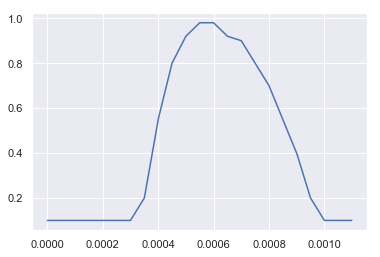

In [291]:
x = np.arange(0., 1100., 1.) * nm
ccd = CCD()
print(ccd)
y = ccd.efficiency(x)
plt.plot(x, y)

In [292]:
n_photoelectrons_CCD       = n_photons_reaching_CCD * ccd.efficiency(laser.lamda)
n_photoelectrons_pixel_CCD = photoelectrons_per_pixel(n_photoelectrons_CCD, ccd)

print('nof photoelectrons reaching CCD = {0:5.1e}'.format(n_photons_reaching_CCD))
print('nof photoelectrons CCD          = {0:5.1e}'.format(n_photoelectrons_CCD))
print('nof photoelectrons per pixel    = {0:5.1e}'.format(n_photoelectrons_pixel_CCD))
print('S/N per pixel                   = {0:5.1e}'.format(np.sqrt(n_photoelectrons_pixel_CCD)))

nof photoelectrons reaching CCD = 2.9e+06
nof photoelectrons CCD          = 2.6e+06
nof photoelectrons per pixel    = 9.8e+00
S/N per pixel                   = 3.1e+00


### The number is consistent with PRL paper.
<img align="center" src="img/prlPhotobleaching.png" width="500" height="500"></img> 

# SABAT experiments: a proposal

## State of the art: Molecule

- F. Cossio and his group have developed a new molecule (C826)
- Measurements with spectrofluoremeter show that the chelated molecule shines with a peak at 425 nm when excited at 250 nm. The unchelated molecule response at that wavelength is rather week. 
- The unchelated molecule shines at 489 nm for all excitations, with higher response when excited with a blue laser (436 nm).

## C826

<img align="center" src="img/dipcCrown_8_2_6.png" width="600" height="600"></img>

- 8+2+6 Crown     : C826, developed by F. Cossio group. 
- Excitation light: 250 nm results in maximum separation between chelated and unchelated molecules


## State of the art: preparation and characterization of C826 monolayers

## Steps:

- Fernando adds a linker to the C826 molecule, so that a monolayer containing only the C826 molecule can be formed attaching molecule to a gold layer (refere to that sample as C826P, P stands for Pure).
- C826P is inspected by the molecular physics group (Celia, Martina, Dimas, MPG from now on). What are the physical parameters that we can measure? Molecule density, monolayer sample, defaults, presence of contaminants?
- C826P is extracted from the vacuum chamber and exposed to atmosphere, then inspected again. What do we observe?
- A second sample is prepared dissolving a barium salt in the solution. Presumably this second sample is saturated with Ba++ ions. Refer to it as C826S (S from saturated). Repeat the same steps than for C826P.
- Finally a third sample is prepared using an ALI (C826A) and inspection is repeated.


## Wet fluorescence experiments

1. Start observing SMFI for C826 in disolution, reproducing the steps of NPRL.
2. The first experiment can be done with the unchelated molecule, shining a laser of 436 nm and observing the fluorescence at 489 nm. This allows us to fully test the setup before using a 250 nm laser to excite the molecule.
3. The second experiment would then use a 250 nm laser and observe SMFI at 425 nm. Let's examine the numbers.

## Laser for UV excitation (chelated molecule):

https://www.rpmclasers.com/product/p4-235-5-2-0-5-236nm-microchip-laser/

https://rpmclasers.com/wp-content/uploads/products/Multi-Wavelength%20Series%20v1_1.pdf

- Wavelength      : 236 nm 
- Beam power      : 1 mW
- Beam energy     : 0.5 muJ per pulse
- Pulse width     : 1.4 nm 
- Beam rate.      : 1 - 10 kHz

- Quote: The price for this laser is 16,173 and has a lead time of 12 weeks ARO.  This price includes the laser head, controller w/ software, power supply and heatsink, so it is everything you need to run the laser right out of the box. 

- STU-01E-100 laser

https://www.gophotonics.com/products/lasers/teem-photonics/29-689-stu-01e-1x0

- Wavelength  : 266 nm 
- Beam power  : 2 mW
- Beam energy : 1 muJ per pulse
- Pulse width : 0.4 ns
- Beam rate.  : 4 kHz

- Quote: About the cost :
- STU-01E-1xx laser unit 8 957 euro.
- MLC-03A-DP1 controller unit 752 euro.
- External trigger (3x) RR mode option xxx–x3x : 299 euro.
- Note: other rep. rate mode options are not charge, ie. 0 euro.
- Lead time : about 8-10 weeks.


## SABAT-SMFI (wet)

### Beam

In [293]:
laser = LaserBeam(lamda = 266 * nm, power = 1 * milliwatt, reprate = 4 * kHZ)
print(laser)
fov = FoV(x = 35 * micron, y = 35 * micron, z = 2 * 488 * nm)
print(fov)
print(f'power density for laser focused in FOV  = {power_density(luv,fov)/(W/cm2):5.1f} W/cm2')
I = photon_density(luv, fov, 1*second)
print(f'photon density for UV laser FOV (per pulse of 1 s)  = {I/(1/cm2):5.1e} ph per cm2')




        Laser:
        lamda                     =2.7e+02 nm
        photon energy             =4.7e+00 eV
        power                     =1.0e+00 mW
        repetition rate           =4.0e+00 kHz
        pulse width               =2.5e-01 ms
        energy per pulse          =2.5e-01 muJ
        

        FOV; x = 3.5e-02 mm; y = 3.5e-02 mm; z = 9.8e-04 mm; area = 1.2e-03 mm2 volume = 1.2e-06 mm3
        
power density for laser focused in FOV  = 163.3 W/cm2
photon density for UV laser FOV (per pulse of 1 s)  = 2.1e+20 ph per cm2


### The number of photons is of the same order than NPR. Assuming the same concentrations of dye and techiques (including TIRF) it should be straight forward to observe SMFI.

### Questions:

- What are the absorption cross-section and qantum yield (or at least its product) of C826? The SMFI experiment should allow us to compare it with Fluo-3

- What is the quenching time compared with Fluo-3?

### One could consider to perform in the same setup a repetition of the NPRL experiment (Fluo-3) to provide a direct comparison with C826.


## Dry fluorescence experiments

- After completion of the wet experiments one could perform several dry experiments:

1. Observe SMFI in unchelated monolayer.
2. Observe SMFI in Barium-spiked (saturated) monolayer. 
3. Observe SMFI in monolayer + Ali drop.

- An important point to decide is whether (1) and (2) can be performed "in air" or need to be performed in vacuum. This depends of the effect on the monolayer of atmosphera. We assume that (3) will be performed in vacuum. 

## Differences between PVA substrates (wet) and monolayer (dry)

- The thickness of a monolayer is very thin. There are no "background molecules", like in the wet case. Therefore, TIRF is not needed. This is afortunate, on the other hand, since TIRF is not possible (no oil) in vacuum. One consequence is that the NA of the microscope will be smaller than one (assume 0.7)
- We need to decide whether to decouple the laser movement and focusing from the objective movement and focusing. Perhpas the simple thing is to couple both and iluminate from behind the sample.
- To perform the experiments we need a transparent substrate, either quartz or ITO. Perhaps quartz is best to start (we don't need an electric field yet), but ITO should also be investigated.
- The photon absorption cross section should be of the same order than Fluo-3

### SABAT Microscope

In [274]:
mc = Microscope(name='SABAT', numerical_aperture=0.7, magnification=100)
print(mc)


        name                 = SABAT
        NA                   =   0.7 
        M                    = 100.0 
        eff dichroic         =  0.85 
        eff filter           =  0.80 
        Optical transmission =  0.07
        Filter  transmission =  0.68
        Total transmission   =  0.05
        


## SMFI in dry


In [294]:
dl = diffraction_limit(laser, mc) 
print(f'the difraction limit in nm is {dl/nm:5.1f}')

the difraction limit in nm is  95.0


#### With an amplification of 100 one could imagine a single molecule in one pixel. The difraction limit will be 10 x 10 mu after amplification, each pixel is 16 mu x 16 mu. Thus one consider a FOV of 160 x 160 nm, or in round number 200 nm. The numbers below show that we can do better than in the PRL, assuming that the cross sections and the quantum yield of the molecule are similar. 

In [297]:
fov = FoV(x = 0.2 * micron, y = 0.2 * micron, z = 1 * nm) # assumes that laser power is quickly attenuatted with R
print(fov)
print(f'power density for laser focused in FOV  = {power_density(luv,fov)/(W/cm2):5.1f} W/cm2')
I = photon_density(luv, fov, 0.5*second)
print(f'photon density for UV laser FOV (per pulse of 500 ms)  = {I/(1/cm2):5.1e} ph per cm2')
flm = fluorescence_per_molecule(m, I, 0.5*second)
print('Fluorescence per molecule and pulse (500 ms) second = {0:5.1e}'.format(flm))

n_photons_reaching_CCD = flm * mc.transmission()
print('nof photoelectrons reaching CCD = {0:5.1e}'.format(n_photons_reaching_CCD))

n_photoelectrons_CCD       = n_photons_reaching_CCD * ccd.efficiency(laser.lamda)
n_photoelectrons_pixel_CCD = photoelectrons_per_pixel(n_photoelectrons_CCD, ccd)

print('nof photoelectrons CCD          = {0:5.1e}'.format(n_photoelectrons_CCD))
print('nof photoelectrons per pixel    = {0:5.1e}'.format(n_photoelectrons_pixel_CCD))
print('S/N per pixel                   = {0:5.1e}'.format(np.sqrt(n_photoelectrons_pixel_CCD)))


        FOV; x = 2.0e-04 mm; y = 2.0e-04 mm; z = 1.0e-06 mm; area = 4.0e-08 mm2 volume = 4.0e-14 mm3
        
power density for laser focused in FOV  = 5000000.0 W/cm2
photon density for UV laser FOV (per pulse of 500 ms)  = 3.1e+24 ph per cm2
Fluorescence per molecule and pulse (500 ms) second = 2.3e+08
nof photoelectrons reaching CCD = 4.6e+07
nof photoelectrons CCD          = 4.6e+06
nof photoelectrons per pixel    = 1.8e+01
S/N per pixel                   = 4.2e+00
